In [1]:
import sys
sys.path.append(sys.path[0]+"/../")
import numpy as np
from config.paths import binary_root, hdf5_root_fast as hdf5_root
import matplotlib.pyplot as plt
import cv2
import timeit
import pybind_kernels.histograms as histograms
sample = '770c_pag'


In [2]:
bins = np.load(f'{hdf5_root}/processed/histograms/{sample}/bins-bone_region0.npz')
print (list(bins.keys()))
print (bins['field_names'])

['x_bins', 'y_bins', 'z_bins', 'r_bins', 'field_bins', 'axis_names', 'field_names', 'suffix', 'mask', 'sample', 'z_offset', 'block_size', 'n_blocks', 'value_ranges']
['edt' 'gauss' 'gauss+edt']


A single row ran in 0.28509165812283754 seconds


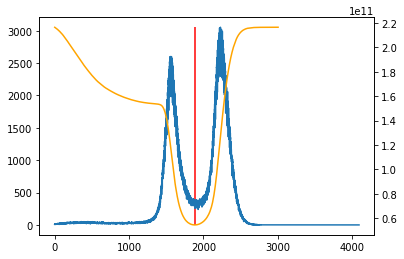

In [3]:
def otsu_crit(row, th):
    w0 = row[:th].sum()
    w1 = row[th:].sum()
    if w0 <= 0 or w1 <= 0:
        return np.inf
    m0 = (1/w0) * (np.arange(th)*row[:th]).sum()
    m1 = (1/w1) * (np.arange(row.shape[0]-th)*row[th:]).sum()
    s0 = (1/w0) * (((np.arange(th)-m0)**2)*row[:th]).sum()
    s1 = (1/w1) * (((np.arange(row.shape[0]-th)-m1)**2)*row[th:]).sum()

    return w0*s0 + w1*s1

test = bins['field_bins'][2,500]#[3000]
test.shape
#test = test / test.sum() # Normalize
thresh_range = np.arange(test.shape[0],dtype=np.uint16)
line_start = timeit.default_timer()
crits = [otsu_crit(test, th) for th in thresh_range]
line_end = timeit.default_timer()
line_time = line_end - line_start
print (f'A single row ran in {line_time} seconds')
best_threshold = thresh_range[np.argmin(crits)]

fig, ax1 = plt.subplots()
ax1.plot(test)
plt.vlines([np.argmin(crits)], test.min(), test.max(), color='red')
ax2 = ax1.twinx()
plt.plot(crits, color='orange')

One image ran through numpy in 10.41833624895662 seconds


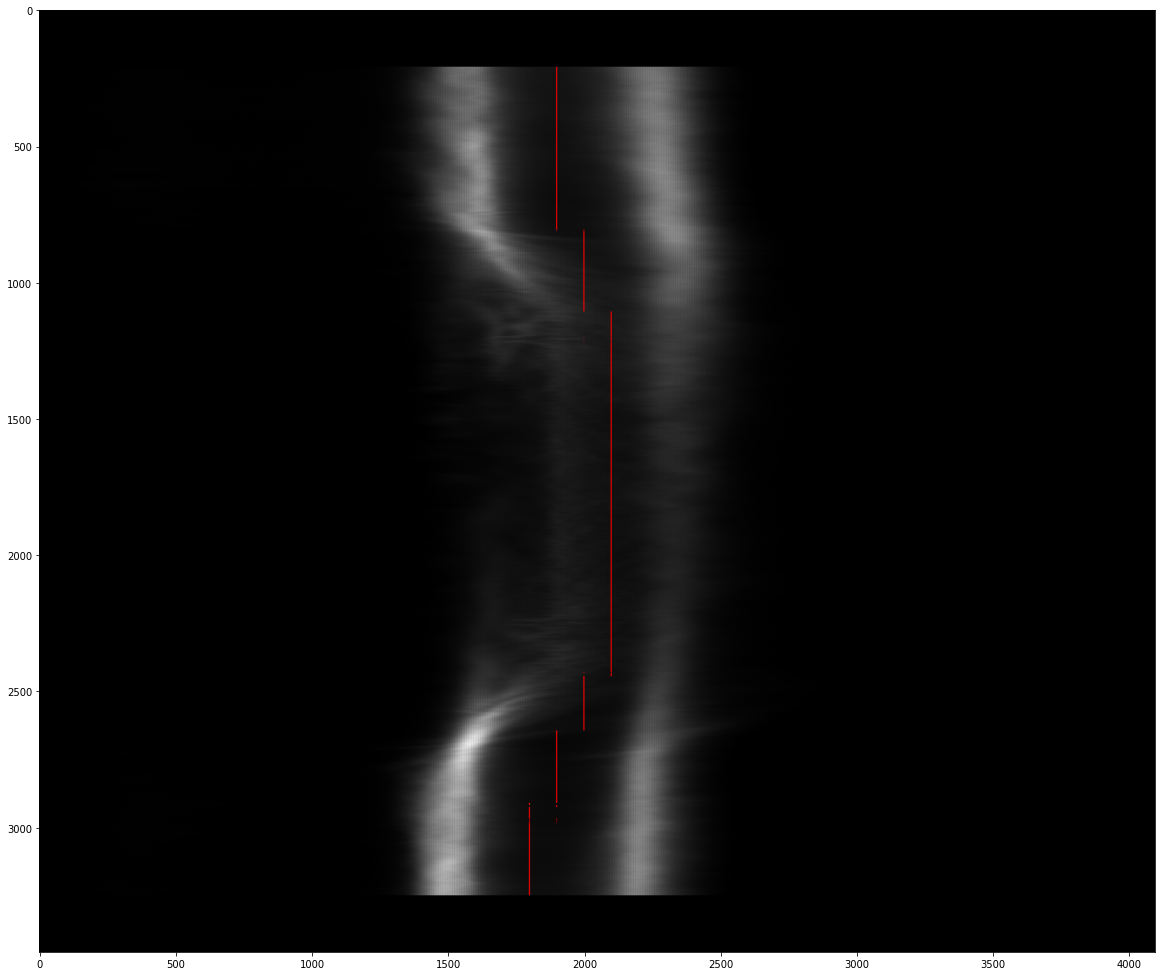

In [4]:
#img = bins['field_bins'][1]
img = bins['x_bins']
display_numpy = ((img / img.max()) * 255).astype(np.uint8)
display_numpy = cv2.cvtColor(display_numpy, cv2.COLOR_GRAY2RGB)
#img_normed = img / img.sum(axis=1)[:, np.newaxis]
numpy_total = 0
for i, row in enumerate(img):
    thresh_range = np.arange(0,row.shape[0],1, np.uint16)
    numpy_start = timeit.default_timer()
    crits = [otsu_crit(row, th) for th in thresh_range]
    best_threshold = thresh_range[np.argmin(crits)]
    numpy_end = timeit.default_timer()
    numpy_total += numpy_end - numpy_start
    display_numpy[i,best_threshold-2:best_threshold+2] = (255,0,0)
print (f'One image ran through numpy in {numpy_total} seconds')
plt.figure(figsize=(20,20))
plt.imshow(display_numpy)

In [6]:
img = bins['x_bins']
display_par = ((img / img.max()) * 255).astype(np.uint8)
display_par = cv2.cvtColor(display_par, cv2.COLOR_GRAY2RGB)
threshs = np.zeros((img.shape[0],), dtype=np.uint64)
par_start = timeit.default_timer()
histograms.otsu(img, threshs, 1)
par_end = timeit.default_timer()
par_time = par_end - par_start
print (f'Parallel ran in {par_time} seconds')
print (f'Which is {numpy_total / par_time} times faster')
if not np.allclose(display_par, display_numpy):
    print (f'Results are not totally equal')

for i, thresh in enumerate(threshs):
    display_par[i,int(thresh)-2:int(thresh)+2] = (255,0,0)
plt.figure(figsize=(20,20))
plt.imshow(display_par)

Parallel ran in 9.929521044017747 seconds
Which is 1.0492284776649294 times faster


NameError: name 'display_numpy' is not defined